# BigQuery and London weather data

[BigQuery](https://cloud.google.com/bigquery/docs/) is a petabyte-scale analytics data warehouse that you can use to run SQL queries over vast amounts of data in near realtime. This page shows you how to get started with the Google BigQuery API using the Python client library.

## Import the libraries used in this tutorial

In [158]:
from google.cloud import bigquery
import pandas as pd
pd.set_option('display.max_columns', 500)

## Initialize a client

To use the BigQuery Python client library, start by initializing a client. The BigQuery client is used to send and receive messages from the BigQuery API.

### Client project
The `bigquery.Client` object uses your default project. Alternatively, you can specify a project in the `Client` constructor. For more information about how the default project is determined, see the [google-auth documentation](https://google-auth.readthedocs.io/en/latest/reference/google.auth.html).


### Client location
Locations are required for certain BigQuery operations such as creating a dataset. If a location is provided to the client when it is initialized, it will be the default location for jobs, datasets, and tables.

Run the following to create a client with your default project:

In [159]:
client = bigquery.Client(location="EU")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: pacific-destiny-243512


To explicitly specify a project when constructing the client, set the `project` parameter:

In [160]:
client = bigquery.Client(location="US", project="my-us-project-244912")
print("Client using specified project: {}".format(client.project))

Client using specified project: my-us-project-244912


## Run a query on a public dataset

Use the [Client.query](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.client.Client.html#google.cloud.bigquery.client.Client.query) method to run the query, and the [QueryJob.to_dataframe](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe) method to return the results as a pandas [`DataFrame`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

<hr>

# How's the weather in London?

#### Data: Daily weather data from NOAA’s Global Historical Climatology Network (GHCN) 
Link to dataset: https://console.cloud.google.com/marketplace/details/noaa-public/ghcn-d

### Goals:
- Query precipitation data for London on BigQuery using the `google.cloud` library
- Plot precipitation data on a lineplot for 2015

### 1. Determine which weather station in London to use

i. Find lat/lon of London, UK  
ii. Using lat/lon range of London, find nearby weather stations

In [161]:
#Choose city/address to retrieve lat/lon coordinates
my_address = "London, UK"

In [162]:
# Get latitude/longitude for London, UK

#!pip install geopy
import geopy
from  geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my-application")

loc = geolocator.geocode(my_address)

print("For my location of [{}], \n my latitude and longitude are: \n [{}, {}].".format(my_address, loc.latitude, loc.longitude))

For my location of [London, UK], 
 my latitude and longitude are: 
 [51.5073219, -0.1276474].


In [163]:
# Using a range of lat/lon coordinates, find weather stations in or near London, UK

query = """
SELECT
  id,
  name,
  state,
  latitude,
  longitude
FROM
  `bigquery-public-data.ghcn_d.ghcnd_stations`
WHERE
  latitude > {}
  AND latitude < {}
  AND longitude > {}
  AND longitude < {}
""".format(loc.latitude - 0.5, loc.latitude + 0.5,
           loc.longitude - 0.5, loc.longitude + 0.5)

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

london_stations = query_job.to_dataframe()
london_stations

,id,name,state,latitude,longitude
0,UKE00105900,ROTHAMSTED,,51.8067,0.3581
1,UKE00105915,HAMPSTEAD,,51.5608,0.1789
2,UKM00003772,HEATHROW,,51.4780,-0.4610


### 2. Retrieve precipitation data for London, UK for a specific year (e.g., 2015)

In [164]:
# Retrieve data for the Heathrow station

stationid = 'UKM00003772' #HEATHROW

query = """
SELECT
  wx.date,
  wx.value/10.0 AS prcp
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
  id = '{}'
  AND qflag IS NULL
  AND element = 'PRCP'
ORDER BY
  wx.date
""".format(stationid)

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query


df = query_job.to_dataframe()
df.head()

,date,prcp
0,2015-01-01,0.3
1,2015-01-02,1.0
2,2015-01-03,3.8
3,2015-01-04,7.1
4,2015-01-05,0.0


#### Filter London precipitation data for 2015 only

In [140]:
# Check 

query = """
SELECT
  date, value as precipitation
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
  date >= "2015-01-01"
  AND date <= "2015-12-31"
  AND id = '{}'
  AND qflag IS NULL
  AND element = 'PRCP'
ORDER BY
  wx.date
""".format(stationid)

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

prcp = query_job.to_dataframe()
prcp.head()

,date,precipitation
0,2015-01-01,3.0
1,2015-01-02,10.0
2,2015-01-03,38.0
3,2015-01-04,71.0
4,2015-01-05,0.0


### 3. Plot precipitation data: London, UK in 2015

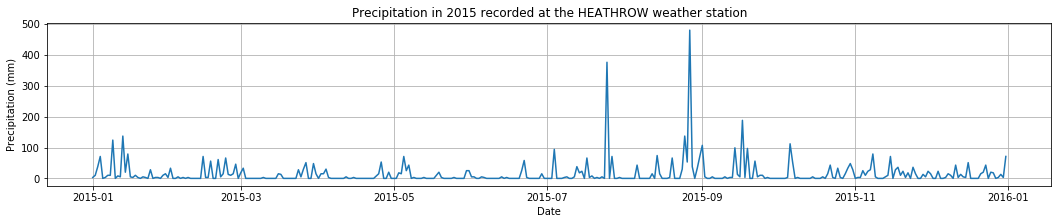

In [141]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [18,3] #change figsize

fig, ax = plt.subplots()
ax.plot(prcp.date.values, prcp.precipitation.values)

ax.set(xlabel='Date', ylabel='Precipitation (mm)',
       title='Precipitation in 2015 recorded at the HEATHROW weather station')
ax.grid()


plt.show()

<hr>

## Analyzing data

#### What interesting questions can we answer?
1. When it rains, does # of cycling trips decrease?
2. How much does it need to rain for cycling trips to drop sharply in London?
3. Do Uber trips increase due to the rain? Is there an inverse relationship between Uber and cycle-rides?
4. Based on Uber data, are Londoners (or Seattlers!) more "tolerant" of rain than in other cities? E.g., do Uber rides spike after a higher threshold of rainfall compared to other major cities?

## How much are Londoners cycling every day in 2015?

In [144]:
# By date

query = """
WITH
  hs AS (
  SELECT
    h.start_date,
    h.start_station_name AS station_name,
    h.duration,
    s.bikes_count
  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id
  WHERE
    h.start_date BETWEEN CAST('2015-01-01' AS TIMESTAMP)
    AND CAST('2016-01-01' AS TIMESTAMP) ),
  stationstats AS (
  SELECT
    CAST(start_date AS DATE) as start_date,
    AVG(duration) AS duration,
    SUM(duration) AS sum_duration,
    COUNT(duration) AS num_trips,
    MAX(bikes_count) AS bikes_count
  FROM
    hs
  GROUP BY
    start_date )
SELECT
  *
FROM
  stationstats
ORDER BY
  start_date ASC
""" 

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="EU",
)  # API request - starts the query


bikehires_d = query_job.to_dataframe()
bikehires_d.head()

,start_date,duration,sum_duration,num_trips,bikes_count
0,2015-01-04,1456.590047,13053960,8962,58
1,2015-01-05,1106.662632,21945120,19830,58
2,2015-01-06,896.384321,18043320,20129,58
3,2015-01-07,1251.158098,27279000,21803,58
4,2015-01-08,910.667195,13799340,15153,58


In [145]:
# By date and station

query = """
WITH
  hs AS (
  SELECT
    h.start_date,
    h.start_station_name AS station_name,
    h.duration,
    s.bikes_count,
    ST_DISTANCE(ST_GEOGPOINT(s.longitude,
        s.latitude),
      ST_GEOGPOINT(-0.1,
        51.5))/1000 AS distance_from_city_center
  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id
  WHERE
    h.start_date BETWEEN CAST('2015-01-01' AS TIMESTAMP)
    AND CAST('2016-01-01' AS TIMESTAMP) ),
  stationstats AS (
  SELECT
    CAST(start_date AS DATE) as start_date,
    station_name,
    AVG(duration) AS duration,
    SUM(duration) AS sum_duration,
    COUNT(duration) AS num_trips,
    MAX(bikes_count) AS bikes_count,
    MAX(distance_from_city_center) AS distance_from_city_center
  FROM
    hs
  GROUP BY
    start_date,station_name )
SELECT
  *
FROM
  stationstats
ORDER BY
  start_date ASC
""" 

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="EU",
)  # API request - starts the query


bikehires_bystation = query_job.to_dataframe()
bikehires_bystation.head()

,start_date,station_name,duration,sum_duration,num_trips,bikes_count,distance_from_city_center
0,2015-01-04,"Brook Green South, Brook Green",1545.000000,12360,8,6,8.041160
1,2015-01-04,"Bow Church Station, Bow",640.000000,3840,6,0,6.438894
2,2015-01-04,"Eaton Square, Belgravia",1560.000000,10920,7,12,3.544709
3,2015-01-04,"Eccleston Place, Victoria",1122.857143,7860,7,12,3.364722
4,2015-01-04,"Aston Street, Stepney",910.000000,5460,6,8,4.595635


## Which days are rainy in 2015?

Over 4mm of rain is considered "heavy rainfall", so let's also tag those days as "need_umbrella": 1 (yes) or 0 (no)

In [146]:
# Check 

query = """
SELECT
  date,
  value,
  IF(value > 4, 1, 0) AS need_umbrella
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
  date >= "2015-01-01"
  AND date <= "2015-12-31"
  AND id = 'UKM00003772'
  AND qflag IS NULL
  AND element = 'PRCP'
ORDER BY
  wx.date
""".format(stationid)

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

prcp = query_job.to_dataframe()
prcp.head()

,date,value,need_umbrella
0,2015-01-01,3.0,0
1,2015-01-02,10.0,1
2,2015-01-03,38.0,1
3,2015-01-04,71.0,1
4,2015-01-05,0.0,0


#### What is the min-max amount of rain in 2015 in London?

142

In [156]:
prcp_summary = prcp.describe()
print(prcp.describe())

print()

print('Out of the {} recorded days, the min & max amount of daily rain was 0 and {},\n\
    and you would need an umbrella on {} days.'.format(prcp_summary.value[0],
                                                       prcp_summary.value[-1],
                                                       prcp.need_umbrella.sum()))

            value  need_umbrella
count  362.000000     362.000000
mean    15.127072       0.392265
std     39.885159       0.488931
min      0.000000       0.000000
25%      0.000000       0.000000
50%      3.000000       0.000000
75%     15.000000       1.000000
max    480.000000       1.000000

Out of the 362.0 recorded days, the min & max amount of daily rain was 0 and 480.0,
    and you would need an umbrella on 142 days.


#### Is there less cycling on rainy days in 2015?

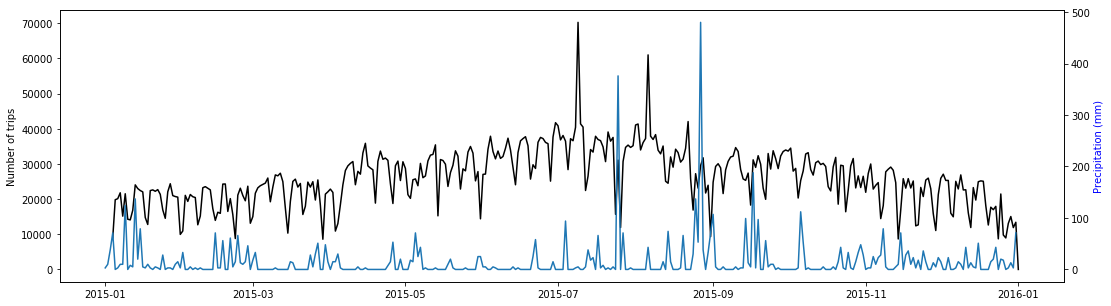

In [94]:
# Lineplot
# y-axis: num_trips
# x-axis: date
# One solid line for num_trips
# One dotted line for daily rainfall in mm

from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [18,5] #change figsize

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(bikehires_d.start_date.values, bikehires_d.num_trips.values, color='black')
ax2.plot(prcp.date.values, prcp.value.values)


ax1.set_ylabel('Number of trips', color='black')
ax2.set_ylabel('Precipitation (mm)', color='b')

ax.set(xlabel='Date',
       title='Precipitation in 2015 recorded at the HEATHROW weather station')
ax.grid()


plt.show()

Hm... it is really hard to tell by just looking at the above plot!

#### Does the number of bicycle trips in a day reduce based on the amount of rain?

In [100]:
## merge the datasets together
bikehires_prcp_d = pd.merge(bikehires_d, prcp, left_on='start_date', right_on='date')
bikehires_prcp_d.head()

,start_date,duration,sum_duration,num_trips,bikes_count,distance_from_city_center,date,value,need_umbrella
0,2015-01-04,1456.590047,13053960,8962,57,9.489655,2015-01-04,71.0,1
1,2015-01-05,1106.662632,21945120,19830,57,9.489655,2015-01-05,0.0,0
2,2015-01-06,896.384321,18043320,20129,57,9.489655,2015-01-06,3.0,0
3,2015-01-07,1251.158098,27279000,21803,57,9.489655,2015-01-07,10.0,1
4,2015-01-08,910.667195,13799340,15153,57,9.489655,2015-01-08,10.0,1


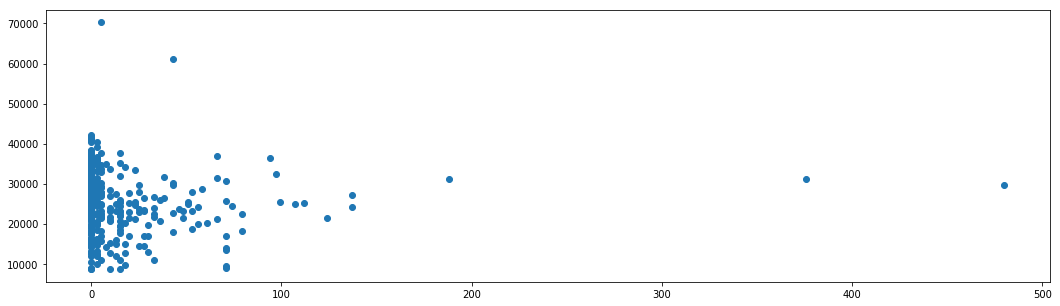

In [103]:
## Scatterplot of num_trips vs. value
plt.scatter(bikehires_prcp_d.value,bikehires_prcp_d.num_trips)

Hmm... still very difficult to visualize any effect of rain on bicycle hires!

~~Idea: what if we included Uber rides to see how precipitation impacts cycle hires AND Uber rides?~~ No Uber data for 2015 available...

#### Maybe we can find clusters of stations that include rainfall, distance from city center, and average duration?

Run k-means on:
- duration of rentals
- number of trips per day
- distance from city center
- rainfall

In [157]:
## Select project
client = bigquery.Client(location="US", project="my-us-project-244912")

## Create new table

# Check 

query = """
CREATE OR REPLACE TABLE
london.london_bike_weather2015
"""

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

<hr>

# <font color="red">Random notes below</font>

## Clustering weather stations in the UK based on their monthly total precipitation

### Goals:
- find monthly precipitation data for every UK weather station
- cluster weather stations based on their monthly total precipitation values using SQL
- plot results on a map

### Where are all the weather stations in the UK?

In [166]:
# Find all UK weather stations

query = """
SELECT
  id,
  name,
  state,
  latitude,
  longitude
FROM
  `bigquery-public-data.ghcn_d.ghcnd_stations`
WHERE
  id LIKE 'UK%'
"""

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

uk_stations = query_job.to_dataframe()
uk_stations

,id,name,state,latitude,longitude
0,UK000044841,HULL,,53.7700,-0.3700
1,UKE00100808,HULL,,53.7667,0.3667
2,UKE00108855,TERRINGTON ST CLEMENT,,52.7450,0.2900
3,UKE00105865,INVERNESS,,57.4867,-4.2231
4,UKE00105926,HAYLING ISLAND,,50.7839,0.9839
5,UKE00105636,KINLOSS,,57.6500,-3.5700
6,UKE00105863,HAWARDEN BRIDGE,,53.2167,-3.0281
7,UKE00105929,RHUM: KINLOCH,,57.0139,-6.2867
8,UKE00105895,SKEGNESS,,53.1467,0.3489
9,UKE00156844,CAWOOD,,53.8275,-1.1467


### Plot weather stations in London

In [169]:
#!pip install folium
import folium

#### Calculate total precipitation data by month for all UK stations in 2015

In [167]:
# Retrieve prcp data for all UK stations


query = """
SELECT
  id,
  EXTRACT(MONTH FROM date) as month,
  sum(value) as prcp
FROM
  `bigquery-public-data.ghcn_d.ghcnd_2015` AS wx
WHERE
  id LIKE 'UK%'
  AND date >= '2015-01-01'
  AND date <= '2015-12-31'
  AND element = 'PRCP'
GROUP BY
  id, month
ORDER BY
  id, month
""" ## LIMIT 10 for sampling

query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query


df = query_job.to_dataframe()
df.head()

,id,month,prcp
0,UK000003005,1,2807.0
1,UK000003005,2,1213.0
2,UK000003005,3,1160.0
3,UK000003005,4,569.0
4,UK000003005,5,1166.0


#### Next tasks:
1. Transpose data (unique id per row, months in columns, prcp as cell values)
2. Cluster similar weather stations in the UK using SQL

<hr>